In [4]:
import h5py
import sys

from diffefwi.diffusion import *
from diffefwi.fwi import *
from diffefwi.plots import *
from diffefwi.utils import *

from scipy.ndimage import gaussian_filter
from argparse import ArgumentParser
from pathlib import Path
from torchaudio.functional import biquad

plt.style.use("../hatsyim.mplstyle")

parser = ArgumentParser(description="Without smoothing and scaled data")
parser.add_argument(
    "--loss_type",
    type=str,
    default='l2',
    help="Type of objective function.",
)
parser.add_argument(
    "--optimizer_type",
    type=str,
    default='adam',
    help="Type of optimization algorithm.",
)
parser.add_argument(
    "--learning_rate",
    type=float,
    default=10.,
    help="Learning rate for non-LBFGS algorithm.",
)
parser.add_argument(
    "--galat",
    type=float,
    default=10.,
    help="Elastic moduli galat bounds.",
)
parser.add_argument(
    "--fwi_iteration",
    type=int,
    default=5,
    help="Number of FWI iterations.",
)

args = parser.parse_args([])
dict_args = vars(args)

from torch.utils.tensorboard import SummaryWriter

save_dir = '../saves/efwi/'
Path(save_dir).mkdir(parents=True, exist_ok=True)

# Set parameters
freq = 10
dx = 25.0
dt = 0.002 # 1ms
nt = int(6 / dt) # 4s
num_dims = 2
num_shots = 10 #259
num_sources_per_shot = 1
num_receivers_per_shot = 199 #256
source_spacing = 399 #30.0
receiver_spacing = 20.0

device = torch.device('cuda')

vp_true = torch.from_numpy(np.load('../saves/efwi/vp_true.npy').reshape(180,-1)).to(device)
vs_true = torch.from_numpy(np.load('../saves/efwi/vs_true.npy').reshape(180,-1)).to(device)
rho_true = torch.from_numpy(np.load('../saves/efwi/rho_true.npy').reshape(180,-1)).to(device)
print(vp_true.shape)

# Mask water column
mask = torch.ones_like(vp_true).to(device)

# Smoothed initial model
vp_init = torch.from_numpy(np.load('../saves/efwi/vp_init.npy').reshape(180,-1)).to(device)
vs_init = vp_to_vs(vp_init)
rho_init = vp_to_rho(vp_init)*1000

# FWI parameters
vp = vp_init.clone().requires_grad_().to(device)
vs = vs_init.clone().requires_grad_().to(device)
rho = rho_init.clone().requires_grad_().to(device)

source_locations = torch.zeros(num_shots, num_sources_per_shot, num_dims)
source_locations[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
source_locations[:, 0, 0] += dx
source_locations = source_locations/10

source_amplitudes_init = (
    deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
    .repeat(num_shots, num_sources_per_shot, 1)
    .to(device)
)
source_amplitudes = source_amplitudes_init.clone()
source_amplitudes = source_amplitudes.to(device)

receiver_locations = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
receiver_locations[:, :, 0] += dx
receiver_locations[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
receiver_locations[:, :, 1] = receiver_locations[0, :, 1].repeat(num_shots, 1)
receiver_locations = receiver_locations/10

# Propagate
receiver_amplitudes_true = deepwave.elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_true, vs_true, rho_true),
    dx, dt, source_amplitudes_y=source_amplitudes.to(device),
    source_locations_y=source_locations.to(device),
    receiver_locations_y=receiver_locations.to(device),
    accuracy=4,
    pml_freq=freq,
    # pml_width=[0, 50, 50, 50]
)[-2]
print(source_amplitudes.shape, source_locations.shape, receiver_locations.shape)

model = UNetModel(
    in_channels=3,
    model_channels=128,
    out_channels=3,
    channel_mult=(1, 2, 4, 8, 16),
    num_res_blocks=3
)
model.to(device)
model.load_state_dict(torch.load('../saves/diffusion/combined.pt'))
timesteps=1000    
ddpm = DenoisingDiffusionProbabilisticModel(timesteps)

# Run Diffusion FWI
vp_diff,vs_diff,rho_diff,loss_fwi_diffusionFWI = ddpm.fwi_sample(
    model, (1, 3, 64, 64),
    900, 
    normalize_vp(
        vp.clone().detach(), vmax=vp_init.max()+args.galat, vmin=vp_init.min()
    ).unsqueeze(0).unsqueeze(0),
    normalize_vs(
        vs.clone().detach(), vmax=vs_init.max()+args.galat, vmin=vs_init.min()             
    ).unsqueeze(0).unsqueeze(0),
    normalize_rho(
        rho.clone().detach(), vmax=rho_init.max()+args.galat, vmin=rho_init.min()  
    ).unsqueeze(0).unsqueeze(0),
    args.fwi_iteration, num_shots, dx, dx, dt,
    receiver_locations, receiver_amplitudes_true.float().to(device),
    source_locations, source_amplitudes, 
    freq=freq, data_weight=[2e8, 2e8],
    loss_type=args.loss_type, learning_rate=20, optim='adam',save_dir=save_dir,
    maxs=[5000,2887,2607], mins=[3000,1732,2294],
    diffusion=True, num_batches=1, use_wandb=False, 
    grad_norm=True, grad_smooth=1,
    inv_source=False, source_illum=None, grad_clip=None
)

# Save results
results = {
'vp_init'   :vp_init.detach().cpu().numpy(),
'vs_init'   :vs_init.detach().cpu().numpy(),
'rho_init'  :rho_init.detach().cpu().numpy(),
'vp_inve'   :vp_diff,
'vs_inve'   :vs_diff,
'rho_inve'  :rho_diff,
'loss'      :loss_fwi_diffusionFWI,
}
torch.save(results,save_dir+'/result.tz')

torch.Size([180, 400])
torch.Size([10, 1, 3000]) torch.Size([10, 1, 2]) torch.Size([10, 199, 2])


In [3]:
# # If you run the above cell until the end
# vp_inve_with = denormalize_vp(results['vp_inve'][-1][0,0,:,:])
# vs_inve_with = denormalize_vs(results['vs_inve'][-1][0,0,:,:])
# rho_inve_with = denormalize_rho(results['rho_inve'][-1][0,0,:,:])

# Load resulsts for the third synthetic near-surfaca case
vp_inve_with = np.load('../saves/efwi/vp_inve_with.npy')
vs_inve_with = np.load('../saves/efwi/vs_inve_with.npy')
rho_inve_with = np.load('../saves/efwi/rho_inve_with.npy')
loss_with = np.load('../saves/efwi/loss_with.npy')

vp_inve_without = np.load('../saves/efwi/vp_inve_without.npy')
vs_inve_without = np.load('../saves/efwi/vs_inve_without.npy')
rho_inve_without = np.load('../saves/efwi/rho_inve_without.npy')
loss_without = np.load('../saves/efwi/loss_without.npy')

vp_init = vp_init.detach().cpu().numpy()
vs_init = vs_init.detach().cpu().numpy()
rho_init = rho_init.detach().cpu().numpy()

Trace at X = 8000 km.


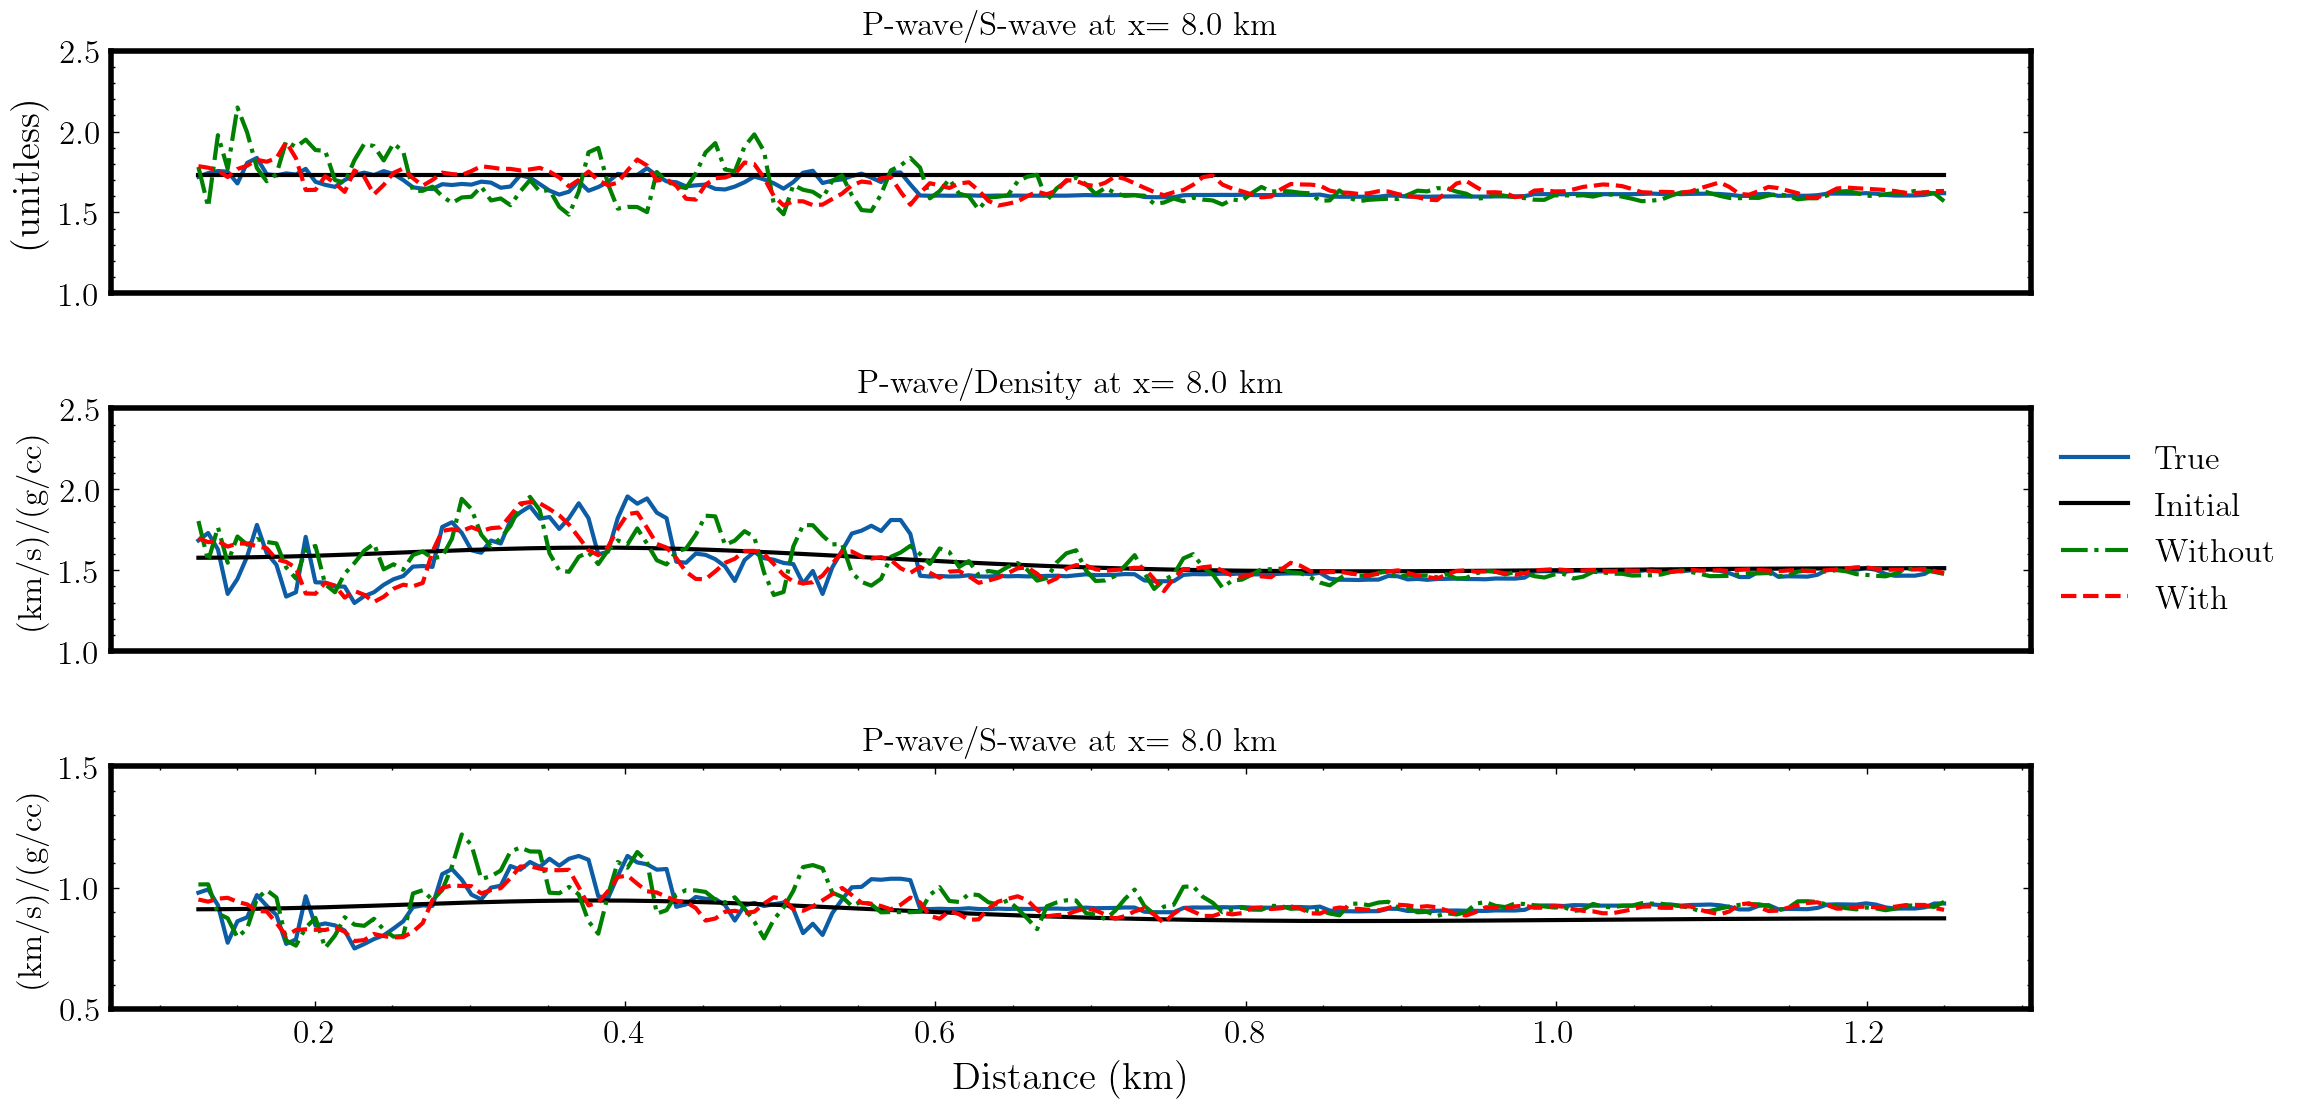

In [4]:
xid = 320

z = np.linspace(0.125,1.25,180)

print('Trace at X = '+str(0+25*xid) + ' km.')

plt.figure(figsize=(12,6))

ax0 = plt.subplot(3,1,1)
ax0.plot(z,(vp_true.detach().cpu().numpy()/vs_true.detach().cpu().numpy())[:,xid], label='True')
ax0.plot(z,(vp_init/vs_init)[:,xid],'k', label='Initial')
ax0.plot(z,(vp_inve_without/vs_inve_without)[:,xid],'-.g', label='Without')
ax0.plot(z,(vp_inve_with/vs_inve_with)[:,xid],'--r', label='With')
ax0.set_ylabel('(unitless)', fontsize=14)
ax0.set_xticks([])
ax0.set_ylim(1,2.5)
ax0.set_title('P-wave/S-wave at x= '+str(0+xid*25/1000)+' km')

ax1 = plt.subplot(3,1,2)
ax1.plot(z,(vp_true.detach().cpu().numpy()/rho_true.detach().cpu().numpy())[:,xid], label='True')
ax1.plot(z,(vp_init/rho_init)[:,xid],'k', label='Initial')
ax1.plot(z,(vp_inve_without/rho_inve_without)[:,xid], '-.g', label='Without')
ax1.plot(z,(vp_inve_with/rho_inve_with)[:,xid],'--r', label='With')
ax1.set_title('P-wave/Density at x= '+str(0+xid*25/1000)+' km')
ax1.set_ylabel('(km/s)/(g/cc)')
ax1.set_ylim(1,2.5)
ax1.set_xticks([])

ax2 = plt.subplot(3,1,3)
ax2.plot(z,(vs_true.detach().cpu().numpy()/rho_true.detach().cpu().numpy())[:,xid], label='True')
ax2.plot(z,(vs_init/rho_init)[:,xid],'k', label='Initial')
ax2.plot(z,(vs_inve_without/rho_inve_without)[:,xid], '-.g', label='Without')
ax2.plot(z,(vs_inve_with/rho_inve_with)[:,xid],'--r', label='With')
ax2.set_xlabel('Distance (km)', fontsize=14)
ax2.set_xlabel('Distance (km)', fontsize=14)
ax2.set_ylim(0.5,1.5)
ax2.set_title('P-wave/S-wave at x= '+str(0+xid*25/1000)+' km')
ax2.set_ylabel('(km/s)/(g/cc)')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large')

plt.tight_layout(pad=2.0)
plt.savefig(save_dir+'/trace_ratio_xid_'+str(xid)+'.pdf')
plt.show()

Trace at X = 8000 km.


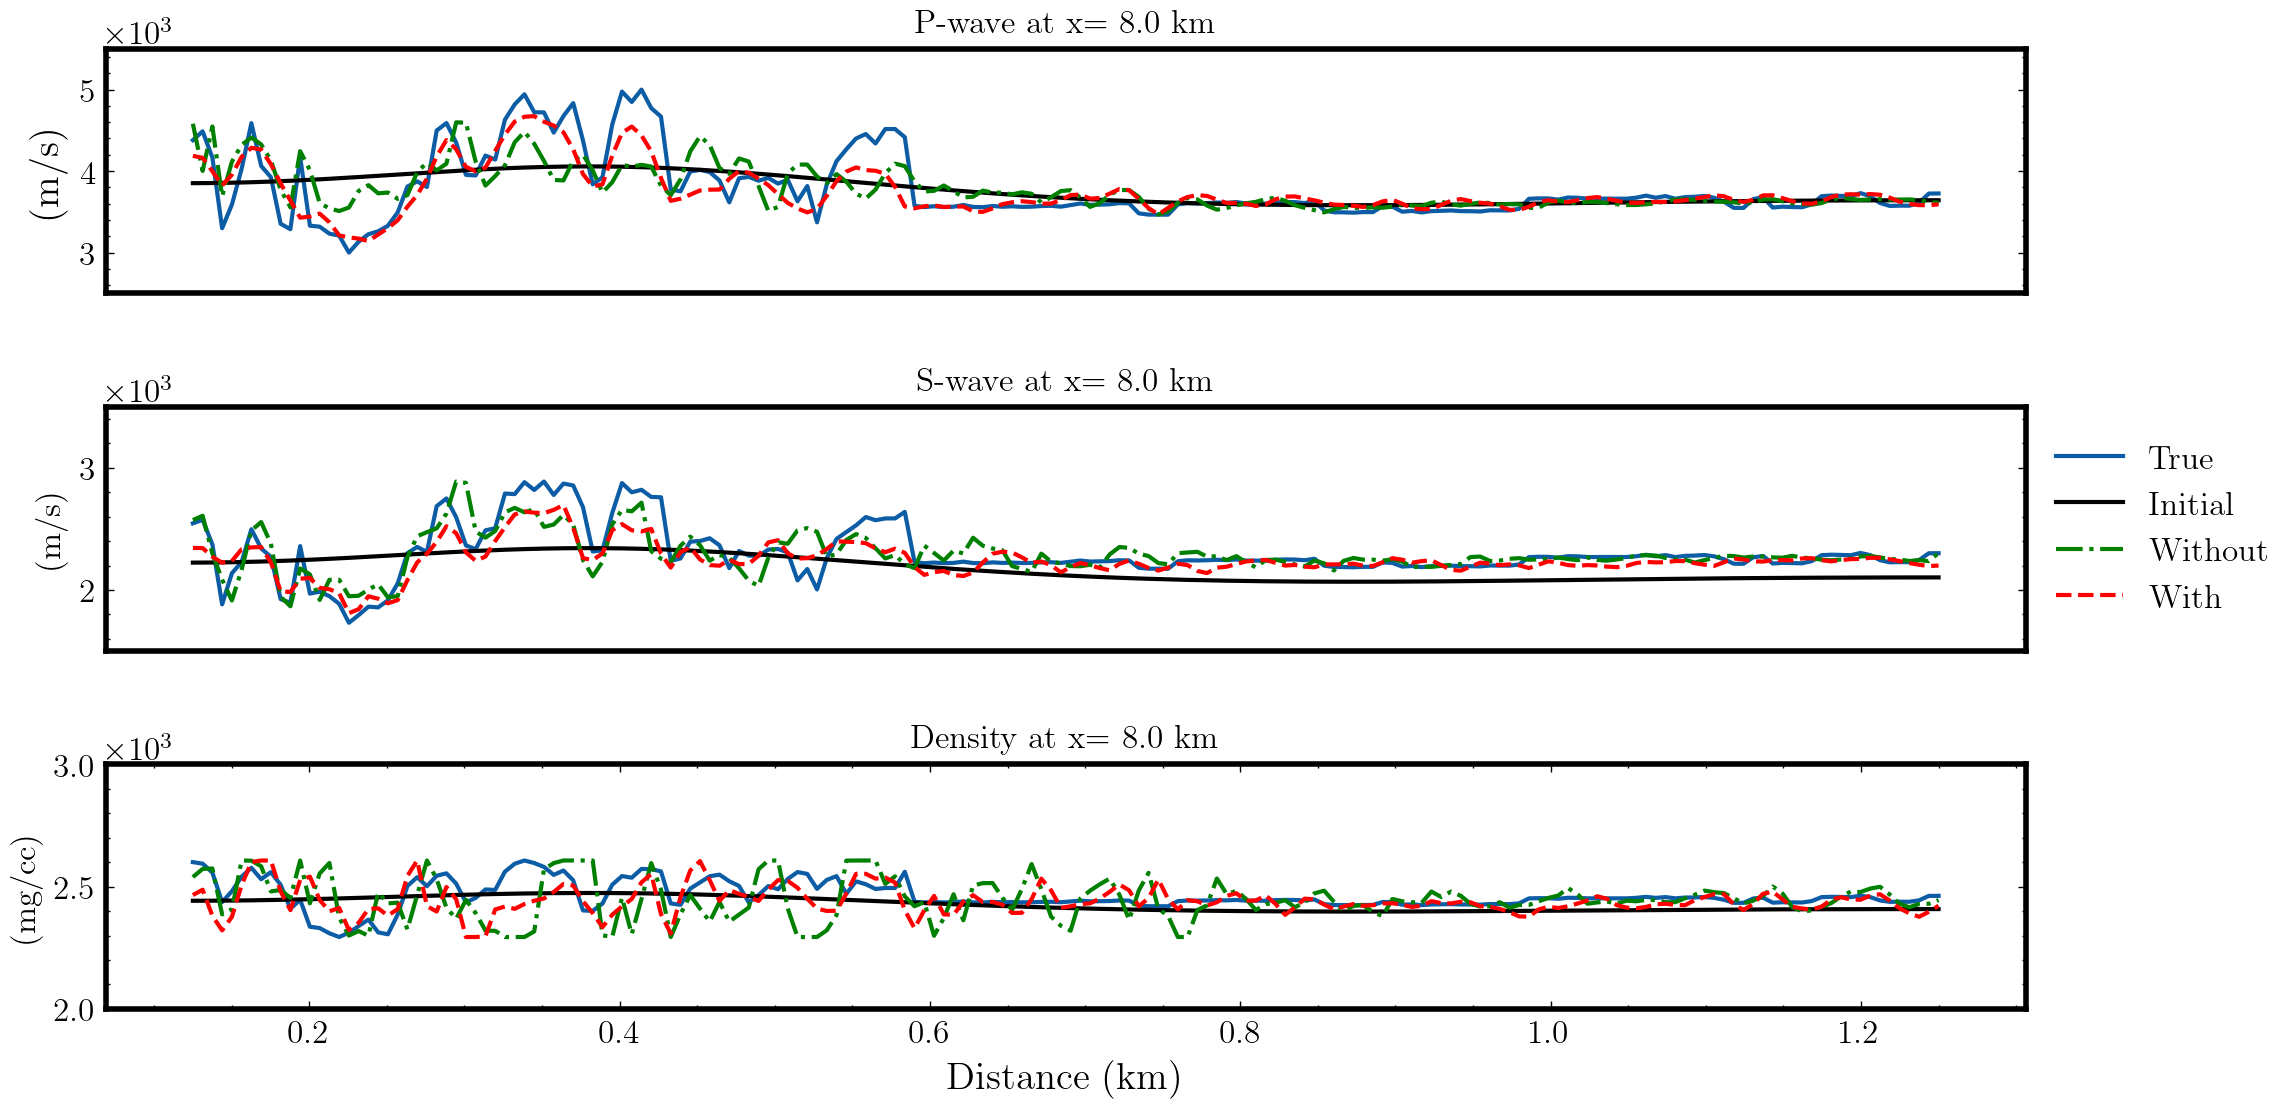

In [5]:
xid = 320

print('Trace at X = '+str(0+25*xid) + ' km.')

plt.figure(figsize=(12,6))

ax0 = plt.subplot(3,1,1)
ax0.plot(z,(vp_true.detach().cpu().numpy())[:,xid], label='True')
ax0.plot(z,(vp_init)[:,xid],'k', label='Initial')
ax0.plot(z,(vp_inve_without)[:,xid], '-.g',label='Without')
ax0.plot(z,(vp_inve_with)[:,xid], '--r', label='With')
ax0.set_ylabel('(m/s)', fontsize=14)
ax0.set_xticks([])
ax0.set_ylim(2500,5500)
ax0.set_title('P-wave at x= '+str(0+xid*25/1000)+' km')
ax0.ticklabel_format(axis='y', style='sci', scilimits=(3,3))

ax1 = plt.subplot(3,1,2)
ax1.plot(z,(vs_true.detach().cpu().numpy())[:,xid], label='True')
ax1.plot(z,(vs_init)[:,xid],'k', label='Initial')
ax1.plot(z,(vs_inve_without)[:,xid], '-.g', label='Without')
ax1.plot(z,(vs_inve_with)[:,xid], '--r', label='With')
ax1.set_title('S-wave at x= '+str(0+xid*25/1000)+' km')
ax1.set_ylabel('(m/s)')
ax1.set_ylim(1500,3500)
ax1.set_xticks([])
ax1.ticklabel_format(axis='y', style='sci', scilimits=(3,3))


ax2 = plt.subplot(3,1,3)
ax2.plot(z,(rho_true.detach().cpu().numpy())[:,xid], label='True')
ax2.plot(z,(rho_init)[:,xid],'k', label='Initial')
ax2.plot(z,(rho_inve_without)[:,xid], '-.g', label='Without')
ax2.plot(z,(rho_inve_with)[:,xid], '--r', label='With')
ax2.set_xlabel('Distance (km)', fontsize=14)
ax2.set_xlabel('Distance (km)', fontsize=14)
ax2.set_title('Density at x= '+str(0+xid*25/1000)+' km')
ax2.set_ylabel('(mg/cc)')
ax2.set_ylim(2000,3000)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(3,3))

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large')

plt.tight_layout(pad=2.0)
plt.savefig(save_dir+'/trace_prop_xid_'+str(xid)+'.pdf')
plt.show()

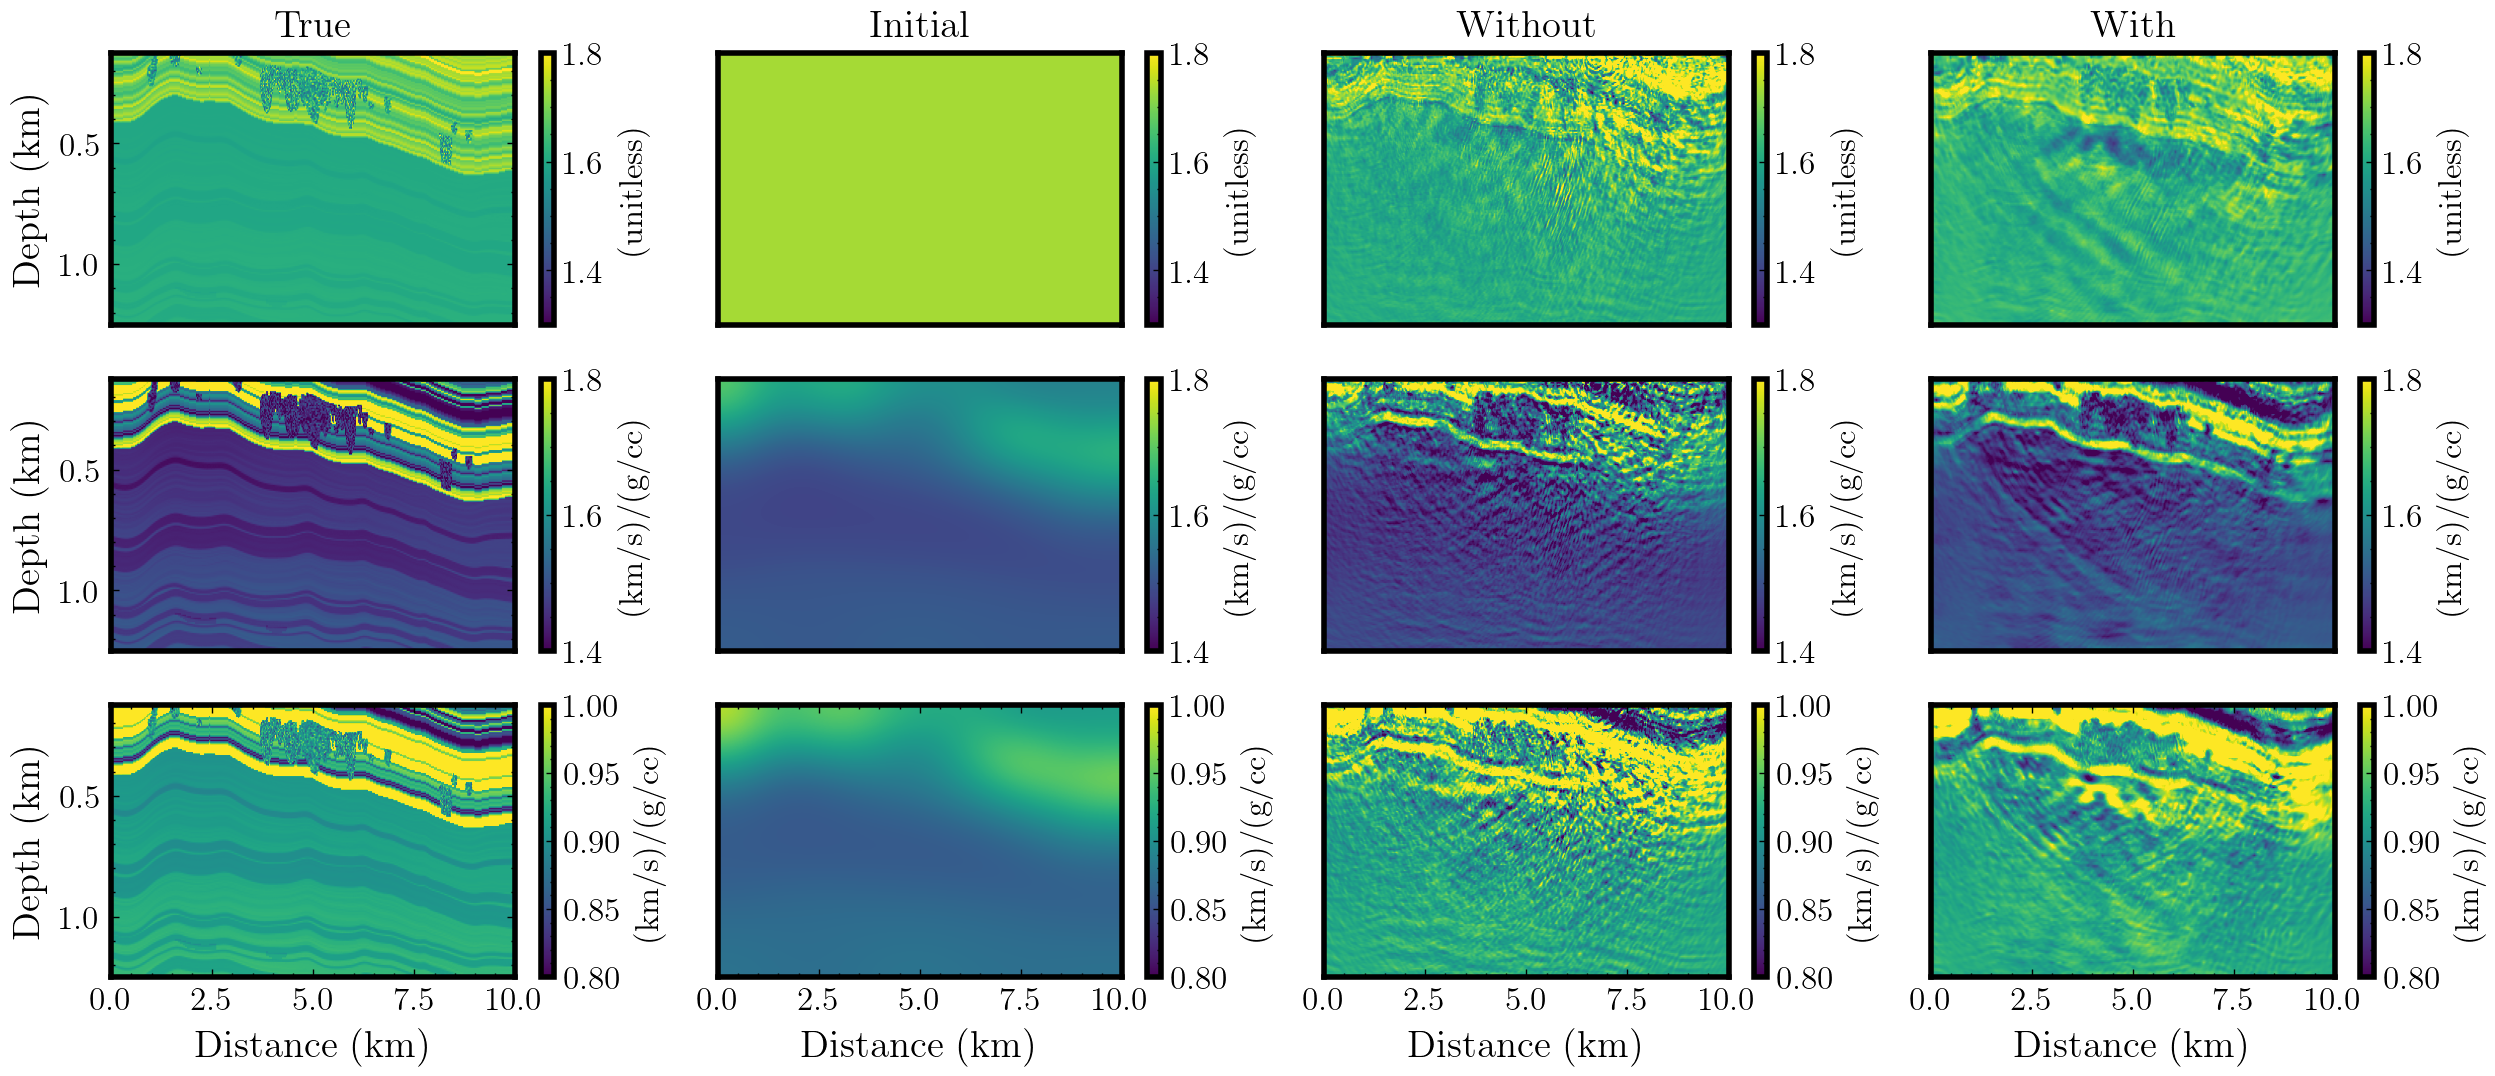

In [6]:
plt.figure(figsize=(15,6))

ax0 = plt.subplot(3,4,1)
plt.imshow(vp_true.detach().cpu().numpy()/vs_true.detach().cpu().numpy(), extent=[0,10,1.25,0.125], vmin=1.3, vmax=1.8, aspect='auto')
plt.ylabel('Depth (km)', fontsize=14)
plt.title('True', fontsize=14)
plt.xticks([])
cbar = plt.colorbar()
cbar.set_label('(unitless)')

plt.subplot(3,4,2)
plt.imshow(vp_init/vs_init, extent=[0,10,1.25,0.125], vmin=1.3, vmax=1.8, aspect='auto')
plt.title('Initial', fontsize=14)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(unitless)')

plt.subplot(3,4,3)
plt.imshow(vp_inve_without/vs_inve_without, extent=[0,10,1.25,0.125], vmin=1.3, vmax=1.8, aspect='auto')
plt.title('Without', fontsize=14)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(unitless)')

plt.subplot(3,4,4)
plt.imshow(vp_inve_with/vs_inve_with, extent=[0,10,1.25,0.125], vmin=1.3, vmax=1.8, aspect='auto')
plt.title('With', fontsize=14)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(unitless)')

ax0 = plt.subplot(3,4,5)
plt.imshow(vp_true.detach().cpu().numpy()/rho_true.detach().cpu().numpy(), extent=[0,10,1.25,0.125], vmin=1.4, vmax=1.8, aspect='auto')
plt.ylabel('Depth (km)', fontsize=14)
plt.xticks([])
cbar = plt.colorbar()
cbar.set_label('(km/s)/(g/cc)')

plt.subplot(3,4,6)
plt.imshow(vp_init/rho_init, extent=[0,10,1.25,0.125], vmin=1.4, vmax=1.8, aspect='auto')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(km/s)/(g/cc)')

plt.subplot(3,4,7)
plt.imshow(vp_inve_without/rho_inve_without, extent=[0,10,1.25,0.125], vmin=1.4, vmax=1.8, aspect='auto')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(km/s)/(g/cc)')

plt.subplot(3,4,8)
plt.imshow(vp_inve_with/rho_inve_with, extent=[0,10,1.25,0.125], vmin=1.4, vmax=1.8, aspect='auto')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(km/s)/(g/cc)')

ax0 = plt.subplot(3,4,9)
plt.imshow(vs_true.detach().cpu().numpy()/rho_true.detach().cpu().numpy(), extent=[0,10,1.25,0.125], vmin=0.8, vmax=1., aspect='auto')
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('(km/s)/(g/cc)')

plt.subplot(3,4,10)
plt.imshow(vs_init/rho_init, extent=[0,10,1.25,0.125], vmin=0.8, vmax=1., aspect='auto')
plt.xlabel('Distance (km)', fontsize=14)
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(km/s)/(g/cc)')

plt.subplot(3,4,11)
plt.imshow(vs_inve_without/rho_inve_without, extent=[0,10,1.25,0.125], vmin=0.8, vmax=1., aspect='auto')
plt.xlabel('Distance (km)', fontsize=14)
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(km/s)/(g/cc)')

plt.subplot(3,4,12)
plt.imshow(vs_inve_with/rho_inve_with, extent=[0,10,1.25,0.125], vmin=0.8, vmax=1., aspect='auto')
plt.xlabel('Distance (km)', fontsize=14)
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(km/s)/(g/cc)')


plt.savefig(save_dir+'/ratio.pdf')

plt.show()

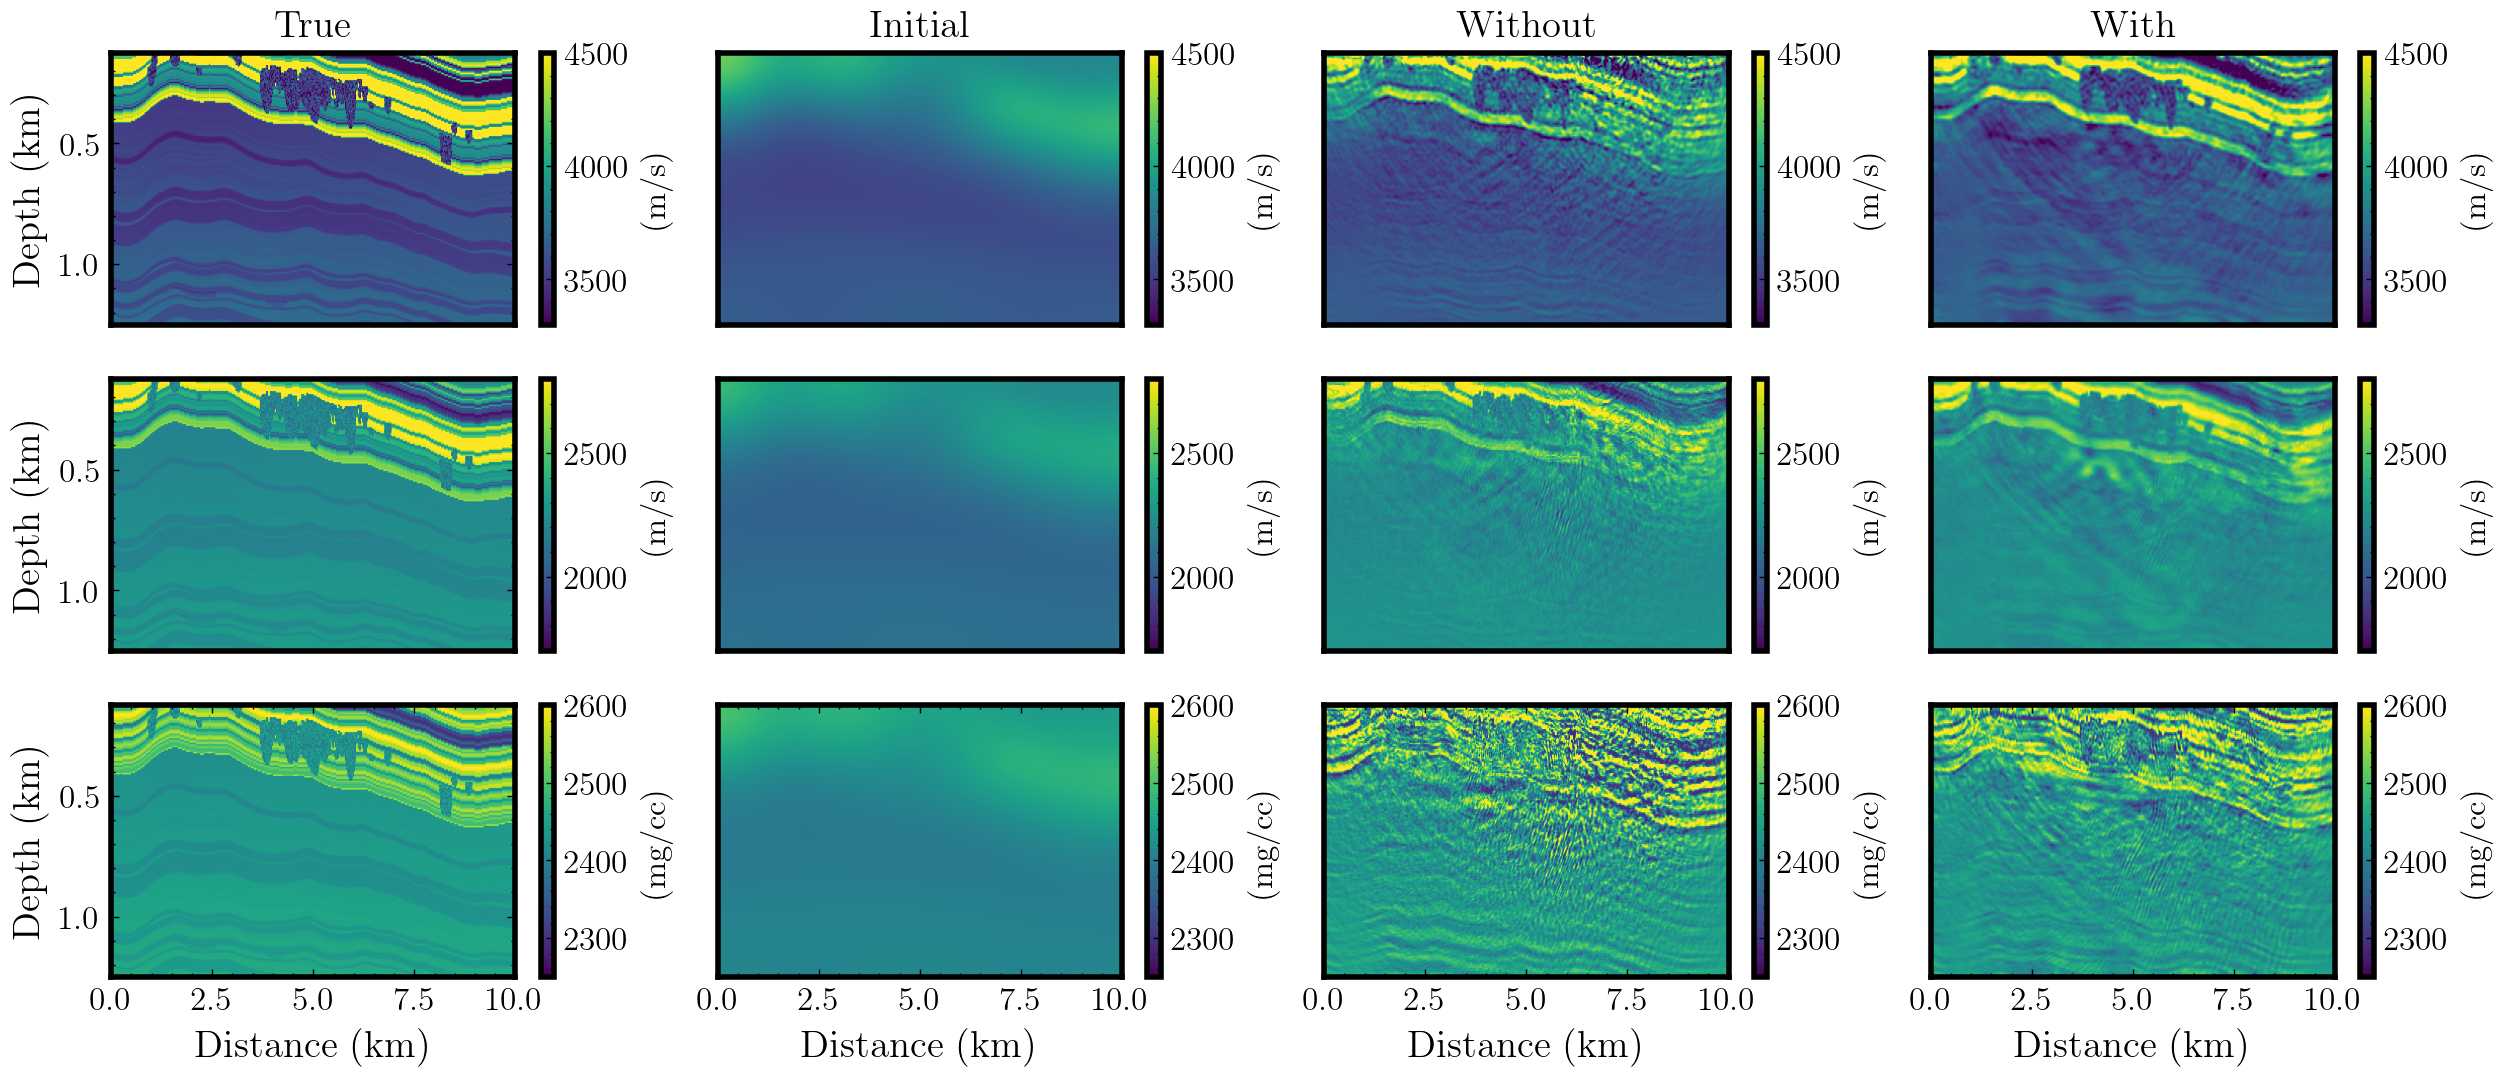

In [7]:
plt.figure(figsize=(15,6))

ax0 = plt.subplot(3,4,1)
plt.imshow(vp_true.detach().cpu().numpy(), extent=[0,10,1.25,0.125], vmin=3300, vmax=4500, aspect='auto')
plt.ylabel('Depth (km)', fontsize=14)
plt.title('True', fontsize=14)
plt.xticks([])
cbar = plt.colorbar()
cbar.set_label('(m/s)')

plt.subplot(3,4,2)
plt.imshow(vp_init, extent=[0,10,1.25,0.125], vmin=3300, vmax=4500, aspect='auto')
plt.title('Initial', fontsize=14)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(m/s)')

plt.subplot(3,4,3)
plt.imshow(vp_inve_without, extent=[0,10,1.25,0.125], vmin=3300, vmax=4500, aspect='auto')
plt.title('Without', fontsize=14)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(m/s)')

plt.subplot(3,4,4)
plt.imshow(vp_inve_with, extent=[0,10,1.25,0.125], vmin=3300, vmax=4500, aspect='auto')
plt.title('With', fontsize=14)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(m/s)')

ax0 = plt.subplot(3,4,5)
plt.imshow(vs_true.detach().cpu().numpy(), extent=[0,10,1.25,0.125], vmin=1700, vmax=2800, aspect='auto')
plt.ylabel('Depth (km)', fontsize=14)
plt.xticks([])
cbar = plt.colorbar()
cbar.set_label('(m/s)')

plt.subplot(3,4,6)
plt.imshow(vs_init, extent=[0,10,1.25,0.125], vmin=1700, vmax=2800, aspect='auto')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(m/s)')

plt.subplot(3,4,7)
plt.imshow(vs_inve_without, extent=[0,10,1.25,0.125], vmin=1700, vmax=2800, aspect='auto')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(m/s)')

plt.subplot(3,4,8)
plt.imshow(vs_inve_with, extent=[0,10,1.25,0.125], vmin=1700, vmax=2800, aspect='auto')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(m/s)')

ax0 = plt.subplot(3,4,9)
plt.imshow(rho_true.detach().cpu().numpy(), extent=[0,10,1.25,0.125], vmin=2250, vmax=2600, aspect='auto')
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('(mg/cc)')

plt.subplot(3,4,10)
plt.imshow(rho_init, extent=[0,10,1.25,0.125], vmin=2250, vmax=2600, aspect='auto')
plt.xlabel('Distance (km)', fontsize=14)
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(mg/cc)')

plt.subplot(3,4,11)
plt.imshow(rho_inve_without, extent=[0,10,1.25,0.125], vmin=2250, vmax=2600, aspect='auto')
plt.xlabel('Distance (km)', fontsize=14)
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(mg/cc)')

plt.subplot(3,4,12)
plt.imshow(rho_inve_with, extent=[0,10,1.25,0.125], vmin=2250, vmax=2600, aspect='auto')
plt.xlabel('Distance (km)', fontsize=14)
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label('(mg/cc)')

plt.savefig(save_dir+'/moduli.pdf')

plt.show()

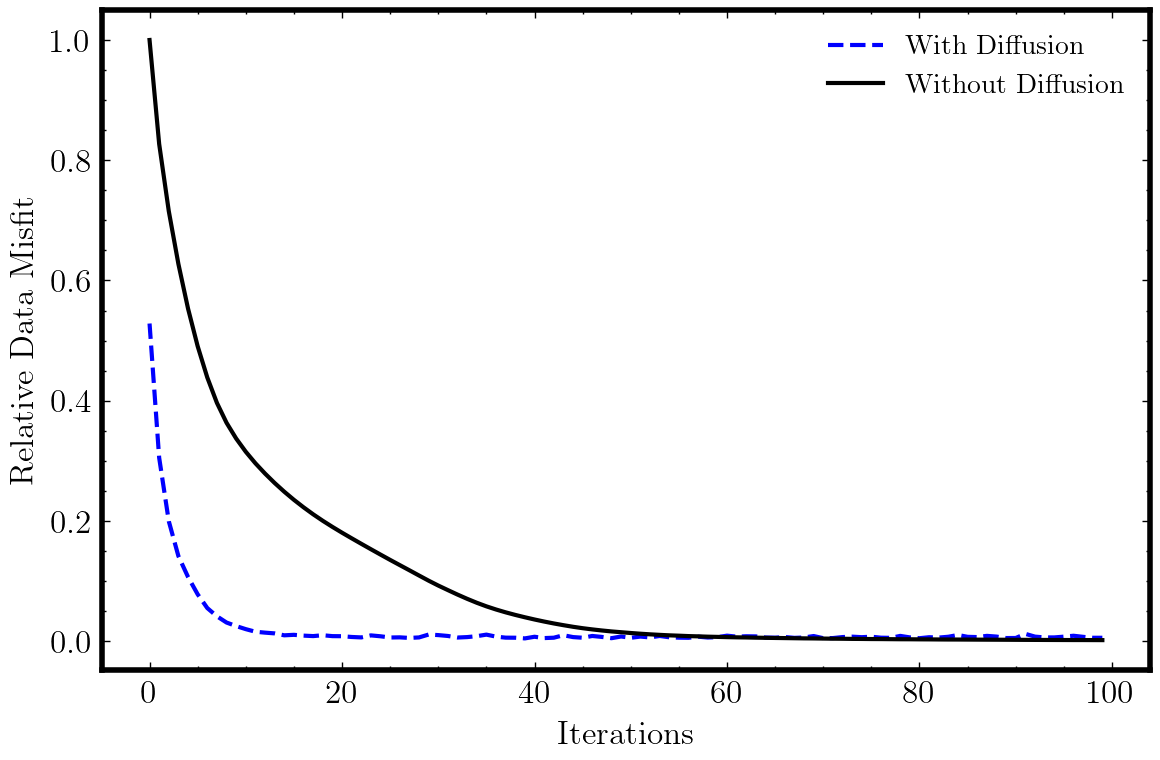

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(loss_with/np.max(loss_without), '--b', label='With Diffusion')
plt.plot(loss_without/np.max(loss_without), 'k', label='Without Diffusion')
plt.ylabel('Relative Data Misfit')
plt.xlabel('Iterations')
plt.legend()
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()
plt.savefig(save_dir+'/loss_comparision.pdf')
plt.show()